In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

import category_encoders as ce

In [2]:
df = pd.read_csv('../data/df_clean_nulls2.csv', index_col=0).drop(columns='city')
df.head()

enrollee_id  city_development_index gender  relevent_experience  \
0         8949                   0.920   Male                    1   
1        29725                   0.776   Male                    0   
2        11561                   0.624    NaN                    0   
3        33241                   0.789    NaN                    0   
4          666                   0.767   Male                    1   

  enrolled_university education_level            major company_size  \
0       no_enrollment        Graduate             STEM          NaN   
1       no_enrollment        Graduate             STEM        50-99   
2           full_time        Graduate             STEM          NaN   
3                 NaN        Graduate  Business Degree          NaN   
4       no_enrollment         Masters             STEM        50-99   

      company_type last_new_job  training_hours  target exp_range  city_group  
0              NaN            1              36     1.0       >20           0  
1  private_limited           >4              47     0.0     11-15           3  
2              NaN        never              83     0.0       2-5           1  
3  private_limited        never              52     1.0       <=1           3  
4   startup_funded            4               8     0.0       >20           3

In [3]:
df.shape

(21213, 14)

# I. Separate Train and Test Sets

In [4]:
train_df = df.loc[df['target'].notna()]
test_df = df.loc[df['target'].isna()]

train_df.shape, test_df.shape

((19084, 14), (2129, 14))

In [5]:
#X_train = train_df.drop(columns=['target', 'city'])
#y_train = train_df.target
#X_test = test_df.drop(columns=['target', 'city'])

#X_train.shape, X_test.shape, y_train.shape

# I. Encoding Categorical Columns

In [6]:
train_df.dtypes[train_df.dtypes=='object']

gender                 object
enrolled_university    object
education_level        object
major                  object
company_size           object
company_type           object
last_new_job           object
exp_range              object
dtype: object

### a) Ordinal Columns

In [7]:
ord_cols = ['education_level', 'company_size', 'last_new_job', 'exp_range']

In [8]:
train_df['education_level'].value_counts()

Graduate          11597
Masters            4361
High School        2013
Phd                 414
Primary School      307
Name: education_level, dtype: int64

In [9]:
ord_map = [
    {'col': 'education_level',
    'mapping': {'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}},
    {'col': 'company_size',
     'mapping': {'<10': 0, '10-49': 1, '50-99': 2, '100-499':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7}},
    {'col': 'last_new_job',
     'mapping': {'never': 0, '1': 1, '2': 2, '3':3, '4':4, '>4':5}},
    {'col': 'exp_range', 
     'mapping': {'<=1':0, '2-5':1, '6-10':2, '11-15':3, '16-20':4,'>20':5}}
]

In [10]:
ord_encoder = ce.OrdinalEncoder(
    cols=ord_cols, mapping=ord_map, return_df=True,
    handle_unknown='return_nan', handle_missing='return_nan'
)

ord_encoder.fit(train_df)

train_df = ord_encoder.transform(train_df)
test_df = ord_encoder.transform(test_df)

In [11]:
train_df.shape, test_df.shape

((19084, 14), (2129, 14))

In [12]:
# Original df

df[ord_cols].head()

education_level company_size last_new_job exp_range
0        Graduate          NaN            1       >20
1        Graduate        50-99           >4     11-15
2        Graduate          NaN        never       2-5
3        Graduate          NaN        never       <=1
4         Masters        50-99            4       >20

In [13]:
# Encoded df

train_df[ord_cols].head()

education_level  company_size  last_new_job  exp_range
0              2.0           NaN           1.0        5.0
1              2.0           2.0           5.0        3.0
2              2.0           NaN           0.0        1.0
3              2.0           NaN           0.0        0.0
4              3.0           2.0           4.0        5.0

In [14]:
train_df[ord_cols].dtypes

education_level    float64
company_size       float64
last_new_job       float64
exp_range          float64
dtype: object

Looks good. After imputing missing values, these columns will be converted to int.

### b) One-Hot Encode Columns

In [15]:
cat_cols = ['gender', 'enrolled_university', 'major', 'company_type']

In [16]:
oh_encoder = ce.OneHotEncoder(cols=cat_cols, return_df=True, use_cat_names=True,
                           handle_unknown='return_nan', handle_missing='return_nan')

oh_encoder.fit(train_df)

train_df = oh_encoder.transform(train_df)
test_df = oh_encoder.transform(test_df)

In [17]:
train_df.shape, test_df.shape

((19084, 32), (2129, 32))

In [18]:
# Create new list of cat_cols

cat_cols2 = []
for i in cat_cols:
    for col_name in train_df.columns:
        if i in col_name:
            cat_cols2.append(col_name)
cat_cols2

['gender_Male',
 'gender_nan',
 'gender_Female',
 'gender_Other',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'enrolled_university_nan',
 'enrolled_university_part_time',
 'major_STEM',
 'major_Business Degree',
 'major_nan',
 'major_Arts',
 'major_Humanities',
 'major_No Major',
 'major_Other',
 'company_type_nan',
 'company_type_private_limited',
 'company_type_startup_funded',
 'company_type_startup_earlystage',
 'company_type_Other',
 'company_type_public_sector',
 'company_type_NGO']

In [19]:
# Original df

df[cat_cols].head()

gender enrolled_university            major     company_type
0   Male       no_enrollment             STEM              NaN
1   Male       no_enrollment             STEM  private_limited
2    NaN           full_time             STEM              NaN
3    NaN                 NaN  Business Degree  private_limited
4   Male       no_enrollment             STEM   startup_funded

In [20]:
# After encoding

train_df[cat_cols2].head()

gender_Male  gender_nan  gender_Female  gender_Other  \
0          1.0         0.0            0.0           0.0   
1          1.0         0.0            0.0           0.0   
2          NaN         NaN            NaN           NaN   
3          NaN         NaN            NaN           NaN   
4          1.0         0.0            0.0           0.0   

   enrolled_university_no_enrollment  enrolled_university_full_time  \
0                                1.0                            0.0   
1                                1.0                            0.0   
2                                0.0                            1.0   
3                                NaN                            NaN   
4                                1.0                            0.0   

   enrolled_university_nan  enrolled_university_part_time  major_STEM  \
0                      0.0                            0.0         1.0   
1                      0.0                            0.0         1.0   
2                      0.0                            0.0         1.0   
3                      NaN                            NaN         0.0   
4                      0.0                            0.0         1.0   

   major_Business Degree  ...  major_Humanities  major_No Major  major_Other  \
0                    0.0  ...               0.0             0.0          0.0   
1                    0.0  ...               0.0             0.0          0.0   
2                    0.0  ...               0.0             0.0          0.0   
3                    1.0  ...               0.0             0.0          0.0   
4                    0.0  ...               0.0             0.0          0.0   

   company_type_nan  company_type_private_limited  \
0               NaN                           NaN   
1               0.0                           1.0   
2               NaN                           NaN   
3               0.0                           1.0   
4               0.0                           0.0   

   company_type_startup_funded  company_type_startup_earlystage  \
0                          NaN                              NaN   
1                          0.0                              0.0   
2                          NaN                              NaN   
3                          0.0                              0.0   
4                          1.0                              0.0   

   company_type_Other  company_type_public_sector  company_type_NGO  
0                 NaN                         NaN               NaN  
1                 0.0                         0.0               0.0  
2                 NaN                         NaN               NaN  
3                 0.0                         0.0               0.0  
4                 0.0                         0.0               0.0  

[5 rows x 22 columns]

### c) Ensure all column dtypes are correct

In [21]:
train_df.dtypes

enrollee_id                            int64
city_development_index               float64
gender_Male                          float64
gender_nan                           float64
gender_Female                        float64
gender_Other                         float64
relevent_experience                    int64
enrolled_university_no_enrollment    float64
enrolled_university_full_time        float64
enrolled_university_nan              float64
enrolled_university_part_time        float64
education_level                      float64
major_STEM                           float64
major_Business Degree                float64
major_nan                            float64
major_Arts                           float64
major_Humanities                     float64
major_No Major                       float64
major_Other                          float64
company_size                         float64
company_type_nan                     float64
company_type_private_limited         float64
company_ty

# II. Imputing Missing Values

### a) Ordinal Columns

In [22]:
# Number of NAs in each column

perc_na = round(train_df[ord_cols].isna().sum() * 100 / len(train_df[ord_cols]), 2)

pd.DataFrame({'Total NA':train_df[ord_cols].isna().sum(), '% NA':perc_na})

Total NA   % NA
education_level       392   2.05
company_size         5864  30.73
last_new_job          390   2.04
exp_range              56   0.29

In [23]:
# Number of NAs in each column

perc_na = round(test_df[ord_cols].isna().sum() * 100 / len(test_df[ord_cols]), 2)

pd.DataFrame({'Total NA':test_df[ord_cols].isna().sum(), '% NA':perc_na})

Total NA   % NA
education_level        52   2.44
company_size          622  29.22
last_new_job           40   1.88
exp_range               5   0.23

In [24]:
KNN_imputer = KNNImputer()

KNN_imputer.fit(train_df[ord_cols])

train_df[ord_cols] = KNN_imputer.transform(train_df[ord_cols])
test_df[ord_cols] = KNN_imputer.transform(test_df[ord_cols])

In [25]:
train_df[ord_cols].isna().sum()

education_level    0
company_size       0
last_new_job       0
exp_range          0
dtype: int64

In [26]:
# Convert ord cols to int

train_df[ord_cols] = round(train_df[ord_cols], 0)
test_df[ord_cols] = round(test_df[ord_cols], 0)

train_df[ord_cols].head()

education_level  company_size  last_new_job  exp_range
0              2.0           3.0           1.0        5.0
1              2.0           2.0           5.0        3.0
2              2.0           3.0           0.0        1.0
3              2.0           4.0           0.0        0.0
4              3.0           2.0           4.0        5.0

In [27]:
train_df['education_level'].value_counts(), test_df['education_level'].value_counts()

(2.0    11831
 3.0     4399
 1.0     2133
 4.0      414
 0.0      307
 Name: education_level, dtype: int64,
 2.0    1300
 3.0     501
 1.0     238
 4.0      54
 0.0      36
 Name: education_level, dtype: int64)

In [28]:
train_df['company_size'].value_counts()

3.0    4743
2.0    4305
4.0    2467
7.0    2019
5.0    1874
1.0    1586
0.0    1471
6.0     619
Name: company_size, dtype: int64

In [29]:
train_df['last_new_job'].value_counts()

1.0    8139
5.0    3286
2.0    3035
0.0    2506
3.0    1075
4.0    1043
Name: last_new_job, dtype: int64

In [30]:
train_df['exp_range'].value_counts()

1.0    5290
2.0    5029
5.0    3281
3.0    2843
4.0    1584
0.0    1057
Name: exp_range, dtype: int64

The distributions don't seem to have changed.

In [31]:
# Convert ord cols to int

train_df[ord_cols] = train_df[ord_cols].astype('int64')
test_df[ord_cols] = test_df[ord_cols].astype('int64')

In [32]:
train_df[ord_cols].dtypes, test_df[ord_cols].dtypes

(education_level    int64
 company_size       int64
 last_new_job       int64
 exp_range          int64
 dtype: object,
 education_level    int64
 company_size       int64
 last_new_job       int64
 exp_range          int64
 dtype: object)

### b) One-Hot Columns

In [33]:
# Number of NAs in each column

perc_na = round(train_df[cat_cols2].isna().sum() * 100 / len(train_df[cat_cols2]), 2)

pd.DataFrame({'Total NA':train_df[cat_cols2].isna().sum(), '% NA':perc_na})

Total NA   % NA
gender_Male                            4438  23.26
gender_nan                             4438  23.26
gender_Female                          4438  23.26
gender_Other                           4438  23.26
enrolled_university_no_enrollment       332   1.74
enrolled_university_full_time           332   1.74
enrolled_university_nan                 332   1.74
enrolled_university_part_time           332   1.74
major_STEM                             2739  14.35
major_Business Degree                  2739  14.35
major_nan                              2739  14.35
major_Arts                             2739  14.35
major_Humanities                       2739  14.35
major_No Major                         2739  14.35
major_Other                            2739  14.35
company_type_nan                       6066  31.79
company_type_private_limited           6066  31.79
company_type_startup_funded            6066  31.79
company_type_startup_earlystage        6066  31.79
company_type_Other                     6066  31.79
company_type_public_sector             6066  31.79
company_type_NGO                       6066  31.79

In [34]:
gender_cols = ['gender_Male', 'gender_Female', 'gender_Other']
enrolled_cols = ['enrolled_university_no_enrollment', 'enrolled_university_full_time', 'enrolled_university_part_time']
major_cols = ['major_STEM', 'major_Business Degree', 'major_Arts', 'major_Humanities', 'major_No Major', 'major_Other']
company = ['company_type_Pvt Ltd', 'company_type_Funded Startup', 'company_type_Early Stage Startup', 'company_type_Other',
           'company_type_Public Sector', 'company_type_NGO']

In [35]:
nan_cols = ['gender_nan', 'enrolled_university_nan', 'major_nan', 'company_type_nan']

# Remove NaN columns from catcols2
[cat_cols2.remove(i) for i in nan_cols]

# Remove NaN cols from df
train_df.drop(columns=nan_cols, inplace=True)
test_df.drop(columns=nan_cols, inplace=True)

cat_cols2

['gender_Male',
 'gender_Female',
 'gender_Other',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'enrolled_university_part_time',
 'major_STEM',
 'major_Business Degree',
 'major_Arts',
 'major_Humanities',
 'major_No Major',
 'major_Other',
 'company_type_private_limited',
 'company_type_startup_funded',
 'company_type_startup_earlystage',
 'company_type_Other',
 'company_type_public_sector',
 'company_type_NGO']

In [36]:
KNN_imputer = KNNImputer(n_neighbors=1)

KNN_imputer.fit(train_df[cat_cols2])

train_df[cat_cols2] = KNN_imputer.transform(train_df[cat_cols2])
test_df[cat_cols2] = KNN_imputer.transform(test_df[cat_cols2])

In [37]:
train_df[cat_cols2].isna().sum()

gender_Male                          0
gender_Female                        0
gender_Other                         0
enrolled_university_no_enrollment    0
enrolled_university_full_time        0
enrolled_university_part_time        0
major_STEM                           0
major_Business Degree                0
major_Arts                           0
major_Humanities                     0
major_No Major                       0
major_Other                          0
company_type_private_limited         0
company_type_startup_funded          0
company_type_startup_earlystage      0
company_type_Other                   0
company_type_public_sector           0
company_type_NGO                     0
dtype: int64

In [38]:
# Convert cat cols to int

train_df[cat_cols2] = round(train_df[cat_cols2], 0)
test_df[cat_cols2] = round(test_df[cat_cols2], 0)

train_df[cat_cols2].head()

gender_Male  gender_Female  gender_Other  \
0          1.0            0.0           0.0   
1          1.0            0.0           0.0   
2          0.0            1.0           0.0   
3          1.0            0.0           0.0   
4          1.0            0.0           0.0   

   enrolled_university_no_enrollment  enrolled_university_full_time  \
0                                1.0                            0.0   
1                                1.0                            0.0   
2                                0.0                            1.0   
3                                1.0                            0.0   
4                                1.0                            0.0   

   enrolled_university_part_time  major_STEM  major_Business Degree  \
0                            0.0         1.0                    0.0   
1                            0.0         1.0                    0.0   
2                            0.0         1.0                    0.0   
3                            0.0         0.0                    1.0   
4                            0.0         1.0                    0.0   

   major_Arts  major_Humanities  major_No Major  major_Other  \
0         0.0               0.0             0.0          0.0   
1         0.0               0.0             0.0          0.0   
2         0.0               0.0             0.0          0.0   
3         0.0               0.0             0.0          0.0   
4         0.0               0.0             0.0          0.0   

   company_type_private_limited  company_type_startup_funded  \
0                           1.0                          0.0   
1                           1.0                          0.0   
2                           0.0                          0.0   
3                           1.0                          0.0   
4                           0.0                          1.0   

   company_type_startup_earlystage  company_type_Other  \
0                              0.0                 0.0   
1                              0.0                 0.0   
2                              0.0                 0.0   
3                              0.0                 0.0   
4                              0.0                 0.0   

   company_type_public_sector  company_type_NGO  
0                         0.0               0.0  
1                         0.0               0.0  
2                         1.0               0.0  
3                         0.0               0.0  
4                         0.0               0.0

In [39]:
train_df[cat_cols2] = train_df[cat_cols2].astype('int64')
test_df[cat_cols2] = test_df[cat_cols2].astype('int64')

train_df[cat_cols2].dtypes

gender_Male                          int64
gender_Female                        int64
gender_Other                         int64
enrolled_university_no_enrollment    int64
enrolled_university_full_time        int64
enrolled_university_part_time        int64
major_STEM                           int64
major_Business Degree                int64
major_Arts                           int64
major_Humanities                     int64
major_No Major                       int64
major_Other                          int64
company_type_private_limited         int64
company_type_startup_funded          int64
company_type_startup_earlystage      int64
company_type_Other                   int64
company_type_public_sector           int64
company_type_NGO                     int64
dtype: object

In [40]:
train_df[gender_cols].value_counts()

gender_Male  gender_Female  gender_Other
1            0              0               16469
0            1              0                2411
             0              1                 204
dtype: int64

In [41]:
df['major'].value_counts()

STEM               16113
Humanities           749
Other                421
Business Degree      364
Arts                 270
No Major             245
Name: major, dtype: int64

In [42]:
train_df[major_cols].value_counts()

major_STEM  major_Business Degree  major_Arts  major_Humanities  major_No Major  major_Other
1           0                      0           0                 0               0              17117
0           0                      0           1                 0               0                669
            1                      0           0                 0               0                432
            0                      0           0                 0               1                381
                                   1           0                 0               0                262
                                   0           0                 1               0                223
dtype: int64

This distribution doesn't seem to follow the original exactly.

In [43]:
train_df.isna().sum(), test_df.isna().sum()

(enrollee_id                          0
 city_development_index               0
 gender_Male                          0
 gender_Female                        0
 gender_Other                         0
 relevent_experience                  0
 enrolled_university_no_enrollment    0
 enrolled_university_full_time        0
 enrolled_university_part_time        0
 education_level                      0
 major_STEM                           0
 major_Business Degree                0
 major_Arts                           0
 major_Humanities                     0
 major_No Major                       0
 major_Other                          0
 company_size                         0
 company_type_private_limited         0
 company_type_startup_funded          0
 company_type_startup_earlystage      0
 company_type_Other                   0
 company_type_public_sector           0
 company_type_NGO                     0
 last_new_job                         0
 training_hours                       0


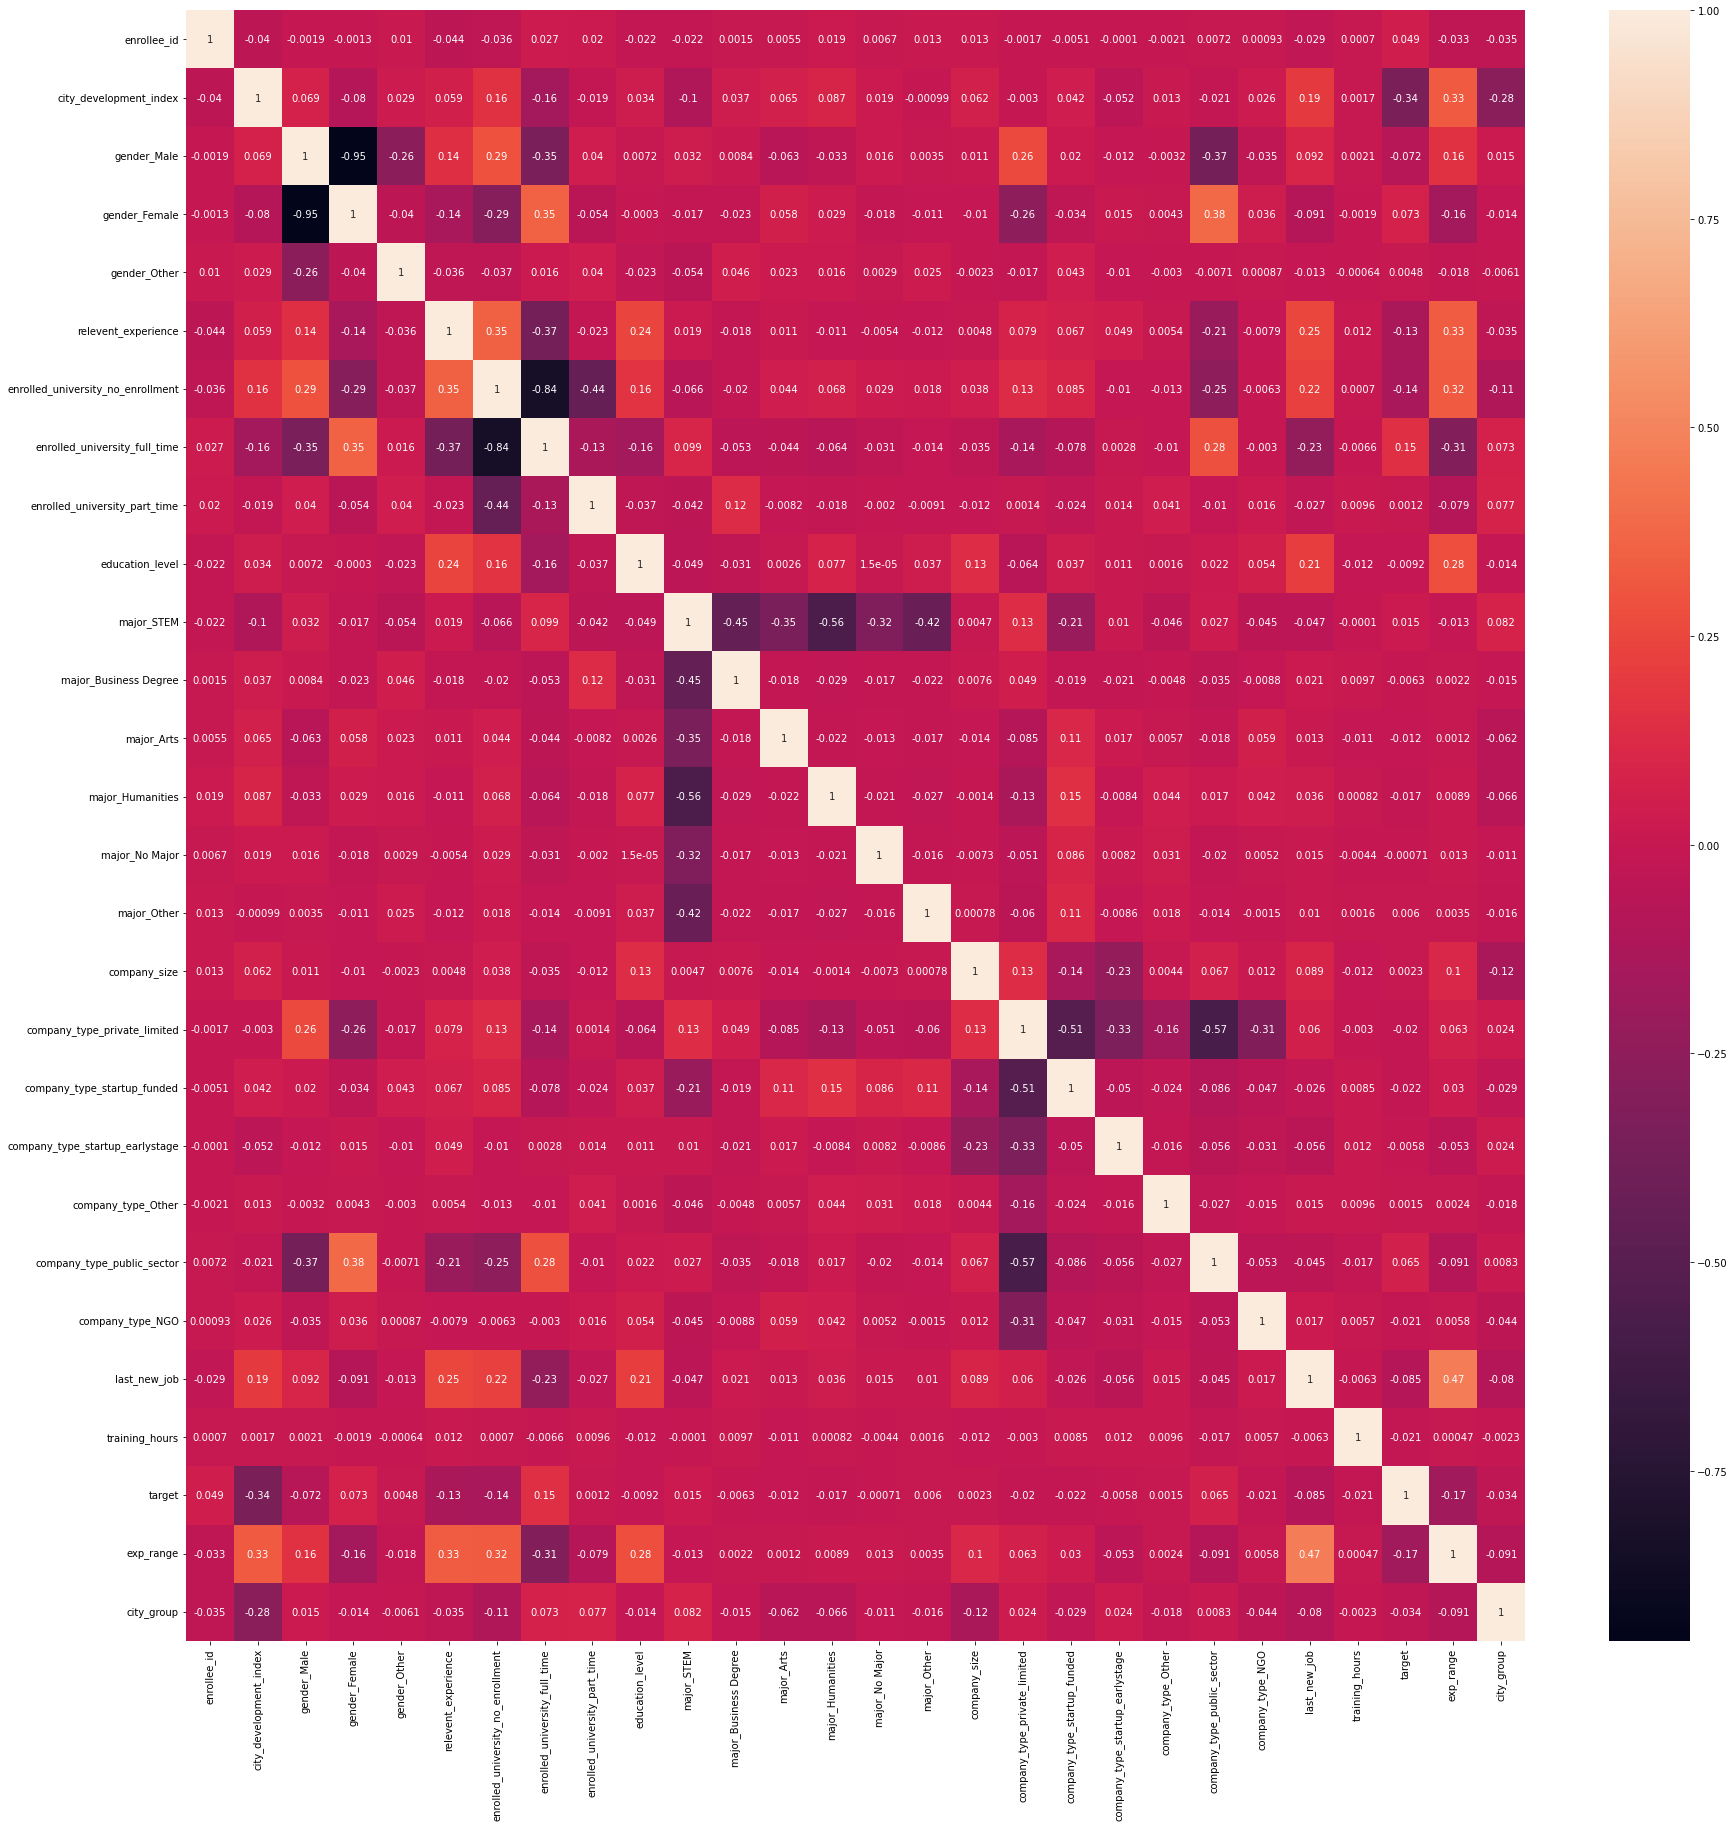

In [44]:
# Check for multicollinearity again, now that all columns are numerical and imputed

plt.figure(figsize=(30,30))
sns.heatmap(train_df.corr(), annot=True);

# III. Save Train/Test Data

In [45]:
# Merge train datasets for model training

#df_train = X_train.copy()
#df_train['target'] = y_train
#train_df.shape

In [46]:
train_df.shape, test_df.shape

((19084, 28), (2129, 28))

In [47]:
train_df.to_csv('../data/Train_Final.csv')
test_df.to_csv('../data/Test_Final.csv')